In [1]:
%pip install pandas numpy seaborn matplotlib scikit-learn xgboost imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

import pickle as pkl

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import StandardScaler as StdScaler
# import hyperopt

from models import decision_tree, k_nearest, logistic_regression, random_forest, support_vector_cls, xgboost

In [3]:
filename = 'with_pca_smote_scaling_feature_selection_without_demographics'
SAVE_DIR = 'Results_NoDemographics/'

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "Results"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "Models"), exist_ok=True)

RESULTS_PATH = os.path.join(SAVE_DIR, 'Results', f'{filename}.csv')
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'Models', f'{filename}.pkl')

In [4]:
CRITERION = 'accuracy'
path = "../../Train Test Splits/"

SEED = 123456
train_split_ratio = 0.70

## Train test split

In [5]:
er_train = pd.read_csv(path + "ER/train.csv")
er_test = pd.read_csv(path + "ER/test.csv")

pr_train = pd.read_csv(path + "PR/train.csv")
pr_test = pd.read_csv(path + "PR/test.csv")

her2_train = pd.read_csv(path + "HER2/train.csv")
her2_test = pd.read_csv(path + "HER2/test.csv")

mol_subtype_train = pd.read_csv(path + "Mol_Subtype/train.csv")
mol_subtype_test = pd.read_csv(path + "Mol_Subtype/test.csv")

In [6]:
er_train, er_val = train_test_split(er_train, train_size = train_split_ratio, random_state = SEED, stratify = er_train['label'])
pr_train, pr_val = train_test_split(pr_train, train_size = train_split_ratio, random_state = SEED, stratify = pr_train['label'])
her2_train, her2_val = train_test_split(her2_train, train_size = train_split_ratio, random_state = SEED, stratify = her2_train['label'])
mol_subtype_train, mol_subtype_val = train_test_split(mol_subtype_train, train_size = train_split_ratio, random_state = SEED, stratify = mol_subtype_train['label'])

### Feature selection

In [7]:
# Performing automated feature selection using XGBoost
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

def feature_selection_xgboost(df):
    X = df.drop(columns = 'label')
    y = df[['label']]
    model = XGBClassifier()
    model.fit(X, y)
    # print(model.feature_importances_)

    selection = SelectFromModel(model, threshold=0.01, prefit=True)
    return X.columns[selection.get_support()]

def return_feats(df, feat_names):
    return df[feat_names]


In [8]:
er_feats = feature_selection_xgboost(er_train)
pr_feats = feature_selection_xgboost(pr_train)
her2_feats = feature_selection_xgboost(her2_train)
mol_subtype_feats = feature_selection_xgboost(mol_subtype_train)

In [9]:
train_x_er, train_y_er = er_train.drop(columns = ['label']), er_train['label']
test_x_er, test_y_er = er_test.drop(columns = ['label']), er_test['label']
val_x_er, val_y_er = er_val.drop(columns = ['label']), er_val['label']

train_x_pr, train_y_pr = pr_train.drop(columns = ['label']), pr_train['label']
test_x_pr, test_y_pr = pr_test.drop(columns = ['label']), pr_test['label']
val_x_pr, val_y_pr = pr_val.drop(columns = ['label']), pr_val['label']

train_x_her2, train_y_her2 = her2_train.drop(columns = ['label']), her2_train['label']
test_x_her2, test_y_her2 = her2_test.drop(columns = ['label']), her2_test['label']
val_x_her2, val_y_her2 = her2_val.drop(columns = ['label']), her2_val['label']

train_x_mol_subtype, train_y_mol_subtype = mol_subtype_train.drop(columns = ['label']), mol_subtype_train['label']
test_x_mol_subtype, test_y_mol_subtype = mol_subtype_test.drop(columns = ['label']), mol_subtype_test['label']
val_x_mol_subtype, val_y_mol_subtype = mol_subtype_val.drop(columns = ['label']), mol_subtype_val['label']

## Resampling

### Imbalanced Data

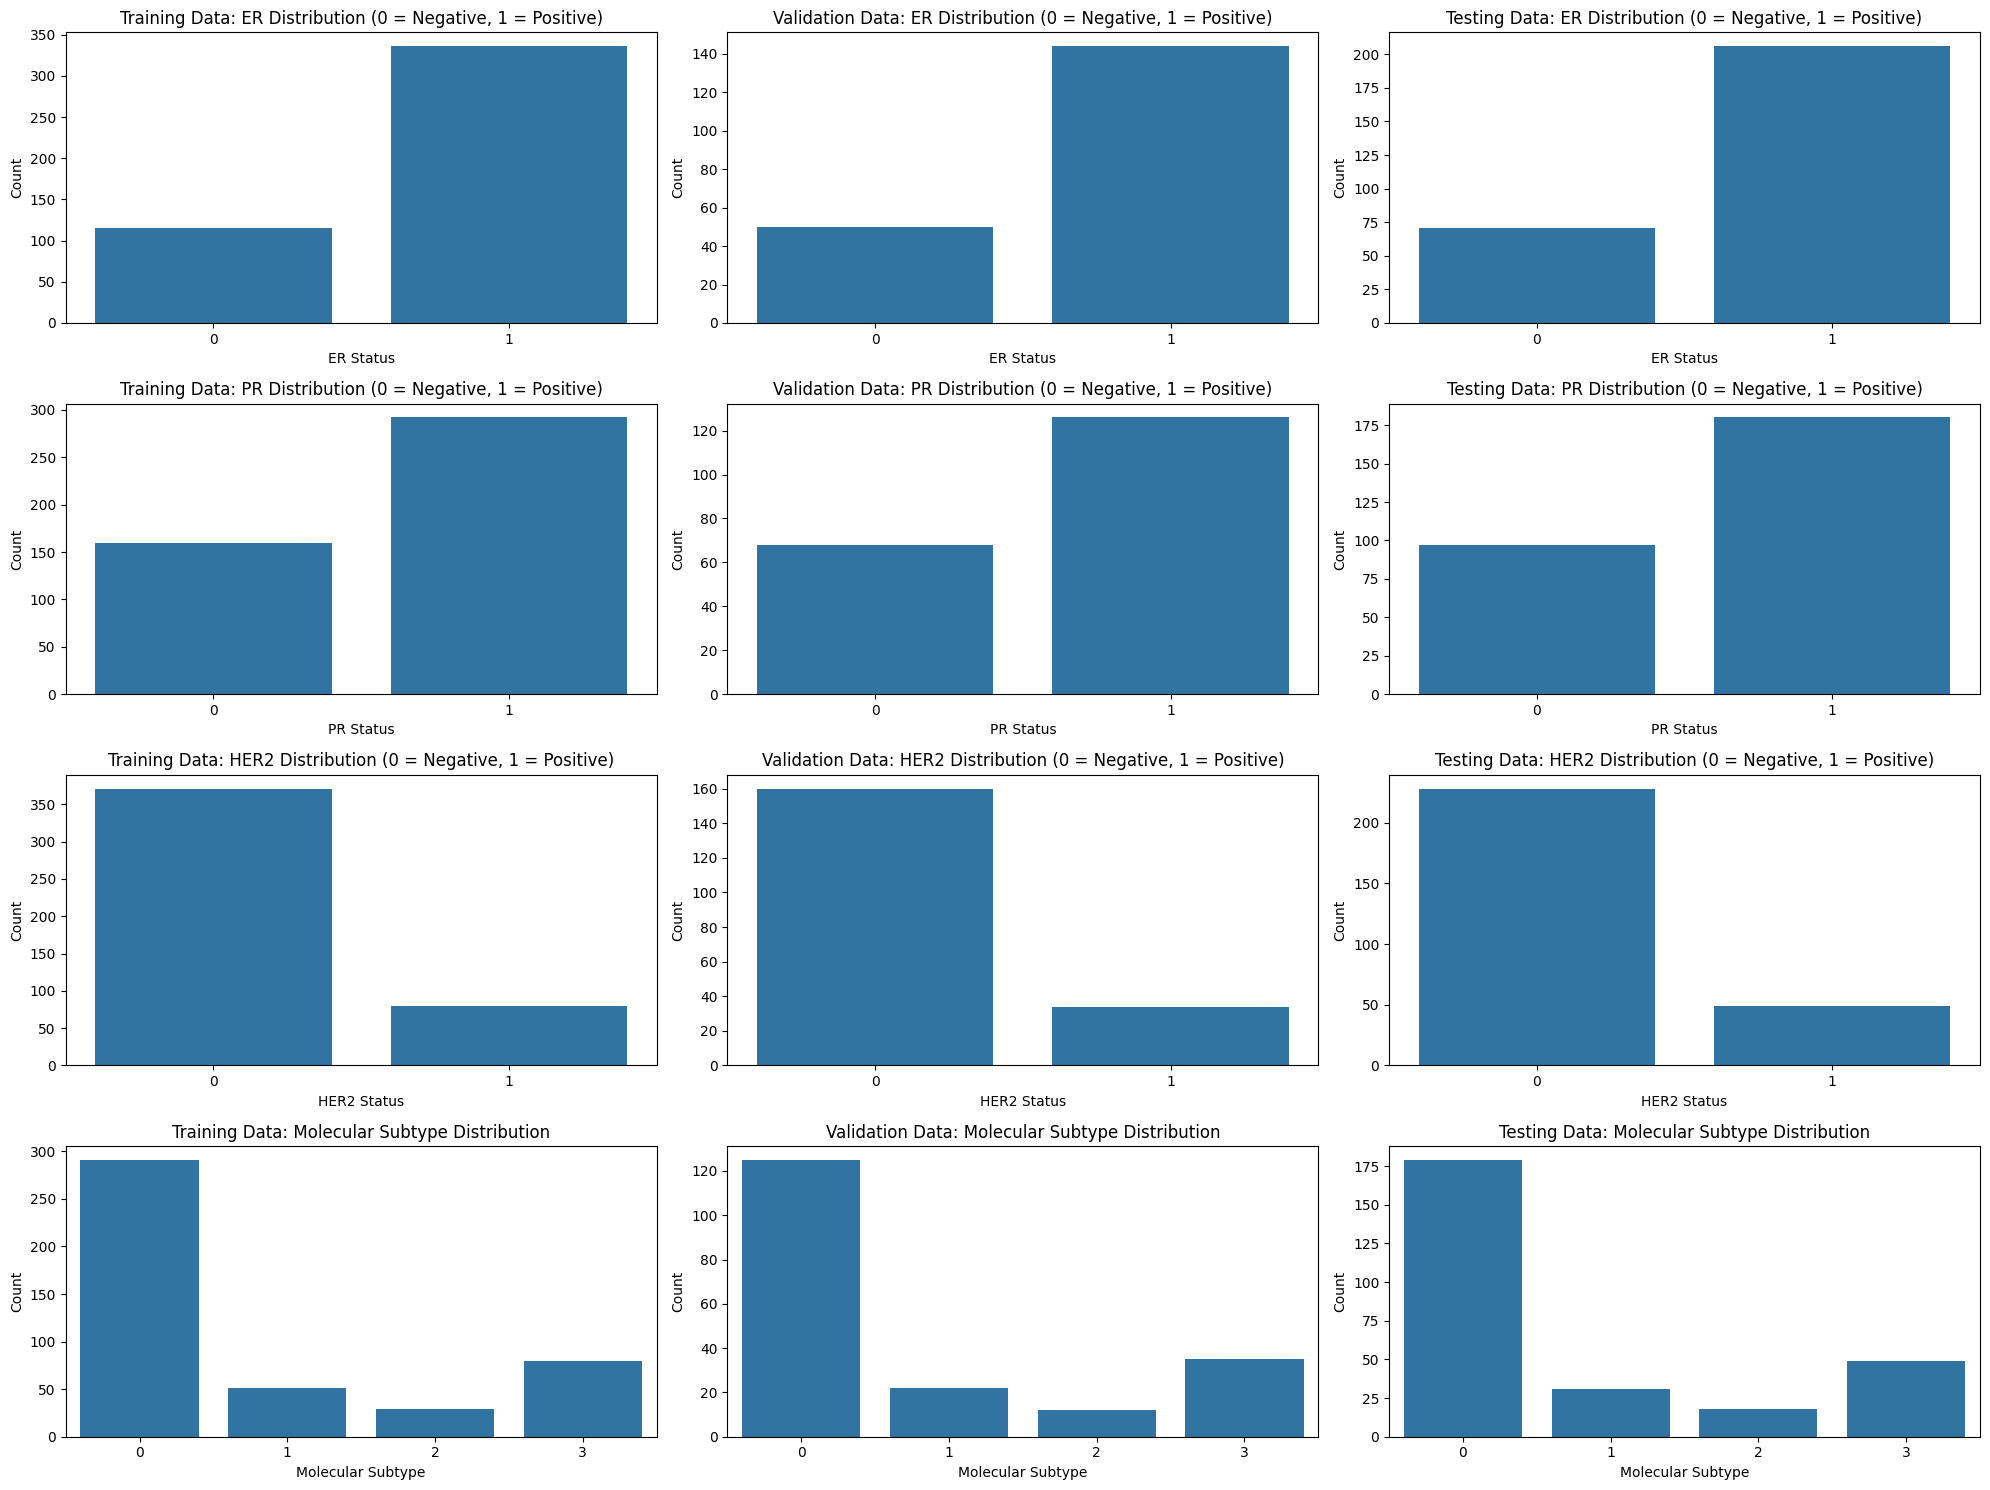

In [10]:
# creating multiple subplots of graph to visualise the above data 
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
plot_data = [[train_y_er, val_y_er, test_y_er], [train_y_pr, val_y_pr, test_y_pr], [train_y_her2, val_y_her2, test_y_her2], [train_y_mol_subtype, val_y_mol_subtype, test_y_mol_subtype]]
for i in range(4):
    for j in range(3):
        sns.countplot(x=plot_data[i][j], ax=axes[i][j])
        if i == 0:
            axes[i][j].set_xlabel('ER Status')
            if j == 0:
                axes[i][j].set_title('Training Data: ER Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: ER Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: ER Distribution (0 = Negative, 1 = Positive)')
        
        elif i == 1:
            axes[i][j].set_xlabel('PR Status')
            if j == 0:
                axes[i][j].set_title('Training Data: PR Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: PR Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: PR Distribution (0 = Negative, 1 = Positive)')
        
        elif i == 2:
            axes[i][j].set_xlabel('HER2 Status')
            if j == 0:
                axes[i][j].set_title('Training Data: HER2 Distribution (0 = Negative, 1 = Positive)')
            elif j == 1:
                axes[i][j].set_title('Validation Data: HER2 Distribution (0 = Negative, 1 = Positive)')
            else:
                axes[i][j].set_title('Testing Data: HER2 Distribution (0 = Negative, 1 = Positive)')
        
        else:
            axes[i][j].set_xlabel('Molecular Subtype')
            if j == 0:
                axes[i][j].set_title('Training Data: Molecular Subtype Distribution')
            elif j == 1:
                axes[i][j].set_title('Validation Data: Molecular Subtype Distribution')
            else:
                axes[i][j].set_title('Testing Data: Molecular Subtype Distribution')

        axes[i][j].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Resampling for Training Samples

In [11]:
# Resampling the training data to balance the dataset using SMOTE

from imblearn.over_sampling import SMOTE

def resample_data_smote(x, y):
    sm = SMOTE(random_state = SEED)
    x_res, y_res = sm.fit_resample(x, y)
    return x_res, y_res

train_x_er_sam, train_y_er_sam = resample_data_smote(train_x_er, train_y_er)
# train_x_pr_sam, train_y_pr_sam = resample_data_smote(train_x_pr, train_y_pr)
train_x_her2_sam, train_y_her2_sam = resample_data_smote(train_x_her2, train_y_her2)
# train_x_mol_subtype_sam, train_y_mol_subtype_sam = resample_data_smote(train_x_mol_subtype, train_y_mol_subtype)

In [12]:
train_x_er = train_x_er_sam.copy()
train_y_er = train_y_er_sam.copy()

# train_x_pr = train_x_pr_sam.copy()
# train_y_pr = train_y_pr_sam.copy()

train_x_her2 = train_x_her2_sam.copy()
train_y_her2 = train_y_her2_sam.copy()

# train_x_mol_subtype = train_x_mol_subtype_sam.copy()
# train_y_mol_subtype = train_y_mol_subtype_sam.copy()

print(train_x_er.shape, train_y_er.shape)
print(train_x_pr.shape, train_y_pr.shape)
print(train_x_her2.shape, train_y_her2.shape)
print(train_x_mol_subtype.shape, train_y_mol_subtype.shape)

(672, 107) (672,)
(451, 107) (451,)
(742, 107) (742,)
(451, 107) (451,)


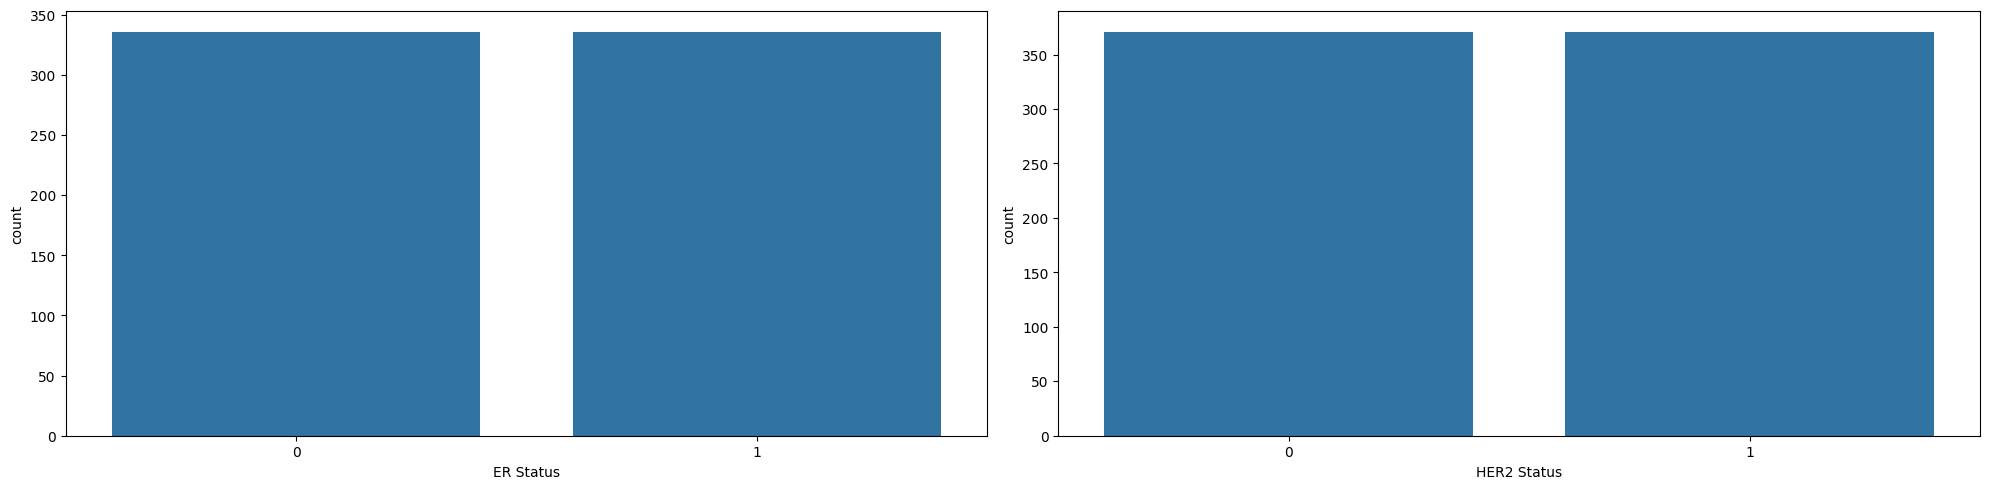

In [13]:
# Plotting the distribution of the resampled data

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=train_y_er, ax=axes[0])
axes[0].set_xlabel('ER Status')

sns.countplot(x=train_y_her2, ax=axes[1])
axes[1].set_xlabel('HER2 Status')

plt.tight_layout()
plt.show()

## Fitting models

In [14]:
classifications_classes = {
    'ER' : (train_x_er, train_y_er, val_x_er, val_y_er, test_x_er, test_y_er, er_feats),
    'PR' : (train_x_pr, train_y_pr, val_x_pr, val_y_pr, test_x_pr, test_y_pr, pr_feats),
    'HER2': (train_x_her2, train_y_her2, val_x_her2, val_y_her2, test_x_her2, test_y_her2, her2_feats),
    'Mol Subtype': (train_x_mol_subtype, train_y_mol_subtype, val_x_mol_subtype, val_y_mol_subtype, test_x_mol_subtype, test_y_mol_subtype, mol_subtype_feats)
}

In [15]:
def get_metrics(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}


In [16]:
def get_NB_model(tx, ty, vx, vy, testx, testy, classification = None):
    nb = GaussianNB()
    nb.fit(tx, ty)
    
    train_metrics = get_metrics(nb, tx, ty, 'train')
    val_metrics = get_metrics(nb, vx, vy, 'val')
    test_metrics = get_metrics(nb, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Naive Bayes'
    if classification is not None:
        result['classification'] = classification

    return result, nb

def get_DT_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Decision Tree model with metrics'''
    model = decision_tree.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Decision Tree'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get KNN model with metrics'''
    model = k_nearest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'KNN'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_LR_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Logistic Regression model with metrics'''
    model = logistic_regression.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Logistic Regression'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_RF_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Random forest model with metrics'''
    model = random_forest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Random Forest'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get SVM model with metrics'''
    model = support_vector_cls.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'SVM'
    if classification is not None:
        result['classification'] = classification

    return result, model
    
def get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get XGBoost model with metrics'''
    model = xgboost.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **train_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'XGBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

In [17]:
classification_results = pd.DataFrame()
models = {}


from sklearn.decomposition import PCA

for key, value in classifications_classes.items():

   tx, ty, vx, vy, testx, testy, feats= value
   
   tx = return_feats(tx, feats)
   vx = return_feats(vx, feats)
   testx = return_feats(testx, feats)
    
   # Applying Feature Scaling to the data using the Standard Scaler
   scaler = Scaler()
   tx = scaler.fit_transform(tx)
   vx = scaler.transform(vx)
   testx = scaler.transform(testx)

   # Applying Principal Component Analysis to the data

   pca = PCA(n_components = 'mle', svd_solver = 'full')
   tx = pca.fit_transform(tx)
   vx = pca.transform(vx)
   testx = pca.transform(testx)

   # Test for data leakage on tx, vs, testx
   
   
   res_nb, nb = get_NB_model(tx, ty, vx, vy, testx, testy, classification = key)
   res_dt, dt = get_DT_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_knn, knn = get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_lr, lr = get_LR_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_rf, rf = get_RF_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_svm, svm = get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_xgb, xgb = get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)

   models[key] = {
                  'Naive Bayes' : nb,
                  'Decision Trees' : dt,
                  'K Nearest Neighbours': knn,
                  'Logistic Regression' : lr,
                  'Random Forest' : rf,
                  'SVM': svm,
                  'XGBoost': xgb
                  }

   classification_results = pd.concat([
         classification_results,
         res_nb,
         res_dt,
         res_knn,
         res_lr,
         res_rf,
         res_svm,
         res_xgb
      ])

c:\ProgramData\Anaconda3\envs\breast_mri_3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\breast_mri_3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\breast_mri_3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\envs\breast_mri_3.11\Lib\site-packages\skl

In [18]:
classification_results

,train_acc,train_prec,train_rec,train_f1,val_acc,val_prec,val_rec,val_f1,test_acc,test_prec,test_rec,test_f1,Algorithm,classification
0,0.608631,0.628104,0.608631,0.593171,0.427835,0.597242,0.427835,0.454502,0.509025,0.659607,0.509025,0.537400,Naive Bayes,ER
0,0.995536,0.995540,0.995536,0.995536,0.984536,0.984702,0.984536,0.984586,0.545126,0.602527,0.545126,0.567801,Decision Tree,ER
0,0.818452,0.820679,0.818452,0.818137,0.664948,0.702012,0.664948,0.678781,0.606498,0.664984,0.606498,0.627138,KNN,ER
0,0.596726,0.609061,0.596726,0.584991,0.649485,0.671834,0.649485,0.659113,0.620939,0.655642,0.620939,0.635177,Logistic Regression,ER
0,0.997024,0.997041,0.997024,0.997024,1.000000,1.000000,1.000000,1.000000,0.703971,0.654017,0.703971,0.668658,Random Forest,ER
0,0.500000,0.250000,0.500000,0.333333,0.742268,0.550962,0.742268,0.632465,0.743682,0.553063,0.743682,0.634363,SVM,ER
0,0.998512,0.998516,0.998512,0.998512,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,XGBoost,ER
0,0.654102,0.625520,0.654102,0.618271,0.644330,0.613163,0.644330,0.611306,0.613718,0.578115,0.613718,0.584000,Naive Bayes,PR
0,0.738359,0.738929,0.738359,0.713396,0.804124,0.821549,0.804124,0.786824,0.620939,0.575040,0.620939,0.576862,Decision Tree,PR
0,0.687361,0.676839,0.687361,0.641016,0.690722,0.681503,0.690722,0.643719,0.620939,0.565098,0.620939,0.564795,KNN,PR


In [19]:
classification_results.to_csv(RESULTS_PATH, index = False)

with open(MODEL_SAVE_PATH, 'wb') as file:
    pkl.dump(models, file)